# r4 Data Science Exercise

On August 24th, I spoke with Katie Sullivan in regard to a position as a data scientist with r4. I received this data challenge and here are my results and process.

### First
I began by opening the excel file, noted it had 4 sheets, one of which was data and the rest were related to the challenge itself.

### Second
I chose to complete this in Python as it is becoming my language of choice, I find that employers prefer it to R (which I am generally stronger in), the visualizations are simpler to handle, and I can easily share the Jupyter Notbook with you in a state that demonstrates the outcome of my operations

### Third
I imported libraries to handle the data and began a short EDA (exploratory data analysis) to determine an idea of what I was working with and to approach the questions that I am posed in A and B.

### Fourth
I want to look at the 

#### Initial EDA and transformations
* Import data by utilizing Pandas 'read' functionality and select the appropriate sheet of the data
* Conduct a quick view with 'head' (transposed to make it easier to read, this is personal preference)
    * Noted the User_ID is some sort of hash, I prefer to categorize by counting numbers as strings because thy aren't meant to be operated upon (e.g. adding social security numbers doesn't make sense, so looking at them as stringed categories is more appropriate)

# Questions

## A - What can you tell me about this data? What is in this data? (5 - 20 min)

## B - Does Portal Page usage shift week-to-week (relative to when an User first used the service)?  (20 - 90 min)

## C - How would you improve Portal Page engagement of Users (relative how a User uses the service)?  (10 - 30 min)

# Answers

## A
* This data is of a longitudinal nature (panel data in econometrics) such that there are n > 1 observations transitioning over time.
    * In lay terms, the data consists of numerous entities throughout time.
* Each observation contains (what appears to be) a hashed (encrypted by some measure) userID, an organization ID that clusters (or groups) the entities, a first use date signifiying the period of initial use of the portal, a use date signifying the period of use for the observation, and a portal page indicating the page used in the observation.
    * In lay terms, each row of data has a user, the organization to which the user belongs, the date of the user's first time on the portal, the specific data 
* Data dimension = M x N = 134,950 x 5
    * Number of Unique IDs = n = 2798
    * Number of Time Periods = t = 34
    * First time period = 2015-01-07
    * Last time period = 2015-02-09

In [28]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from __future__ import division
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

In [29]:
# Importing
df = pd.read_excel('/Users/daiglechris/Git/ConvexOptimizationWithPython/Data/DSx.xlsx', sheet_name = 'Data')
df.head(5)

,User_ID,Org_ID,First_Use_Date,Use_Date,Portal_Page
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube


In [30]:
# Find a few specifics of the data
minDate = df['Use_Date'].min()
maxDate = df['Use_Date'].max()
uniqueDate = df['Use_Date'].nunique()
print('The time span is from {} to {} with {} periods.'.format(minDate, maxDate, uniqueDate))
print()
n = df['User_ID'].nunique()
g = df['Org_ID'].nunique()
print('The number of users is {} under {} groups.'.format(n, g))
print()
pPage = df['Portal_Page'].nunique()
print('There are {} unique portal pages.'.format(pPage))

The time span is from 2015-01-07 00:00:00 to 2015-02-09 00:00:00 with 34 periods.

The number of users is 2798 under 10 groups.

There are 6 unique portal pages.


In [52]:
# Add a column to deal with reasonable values for the User's ID
df['id'] = pd.Categorical((pd.factorize(df['User_ID'])[0] + 1).astype(str))
#df['group'] = pd.Categorical((pd.factorize(df['Org_ID'])[0] + 1).astype(str))
df['group'] = df['Org_ID'].astype('category').cat.rename_categories(range(1, df['Org_ID'].nunique() + 1))
#df['period'] = pd.Categorical((pd.factorize(df['Use_Date'])[0] + 1).astype(str))
df['period'] = df['Use_Date'].astype('category').cat.rename_categories(range(1, df['Use_Date'].nunique() + 1))
df['page'] = pd.Categorical((pd.factorize(df['Portal_Page'])[0] + 1).astype(str))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134950 entries, 0 to 134949
Data columns (total 9 columns):
User_ID           134950 non-null object
Org_ID            134950 non-null object
First_Use_Date    134950 non-null datetime64[ns]
Use_Date          134950 non-null datetime64[ns]
Portal_Page       134950 non-null object
id                134950 non-null category
group             134950 non-null category
period            134950 non-null category
page              134950 non-null category
dtypes: category(4), datetime64[ns](2), object(3)
memory usage: 5.9+ MB


In [53]:
df.describe().T

,count,unique,top,freq,first,last
User_ID,134950,2798,eb43dc75-8c60-487c-9615-4e750042a0e3-26930-7f4...,1096,NaN,NaN
Org_ID,134950,10,EZ,29318,NaN,NaN
First_Use_Date,134950,7,2015-01-07 00:00:00,25134,2015-01-07 00:00:00,2015-01-13 00:00:00
Use_Date,134950,34,2015-01-13 00:00:00,8166,2015-01-07 00:00:00,2015-02-09 00:00:00
Portal_Page,134950,6,Discovery Cube,105489,NaN,NaN
id,134950,2798,2615,1096,NaN,NaN
group,134950,10,4,29318,NaN,NaN
period,134950,34,7,8166,NaN,NaN
page,134950,6,1,105489,NaN,NaN


/Users/daiglechris/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


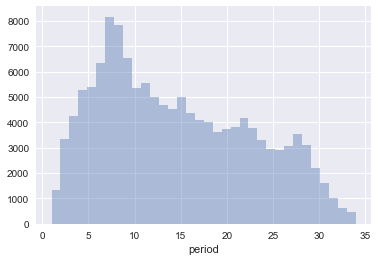

In [54]:
sns.distplot(df['period'], kde = False, bins = 34, hist = True)

/Users/daiglechris/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


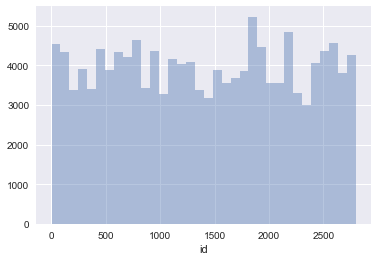

In [55]:
sns.distplot(df['id'].astype(int), kde = False, bins = 34, hist = True)

/Users/daiglechris/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


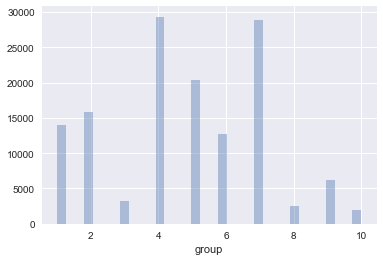

In [56]:
sns.distplot(df['group'].astype(int), kde = False, bins = 34, hist = True)

ValueError: left cannot be >= right

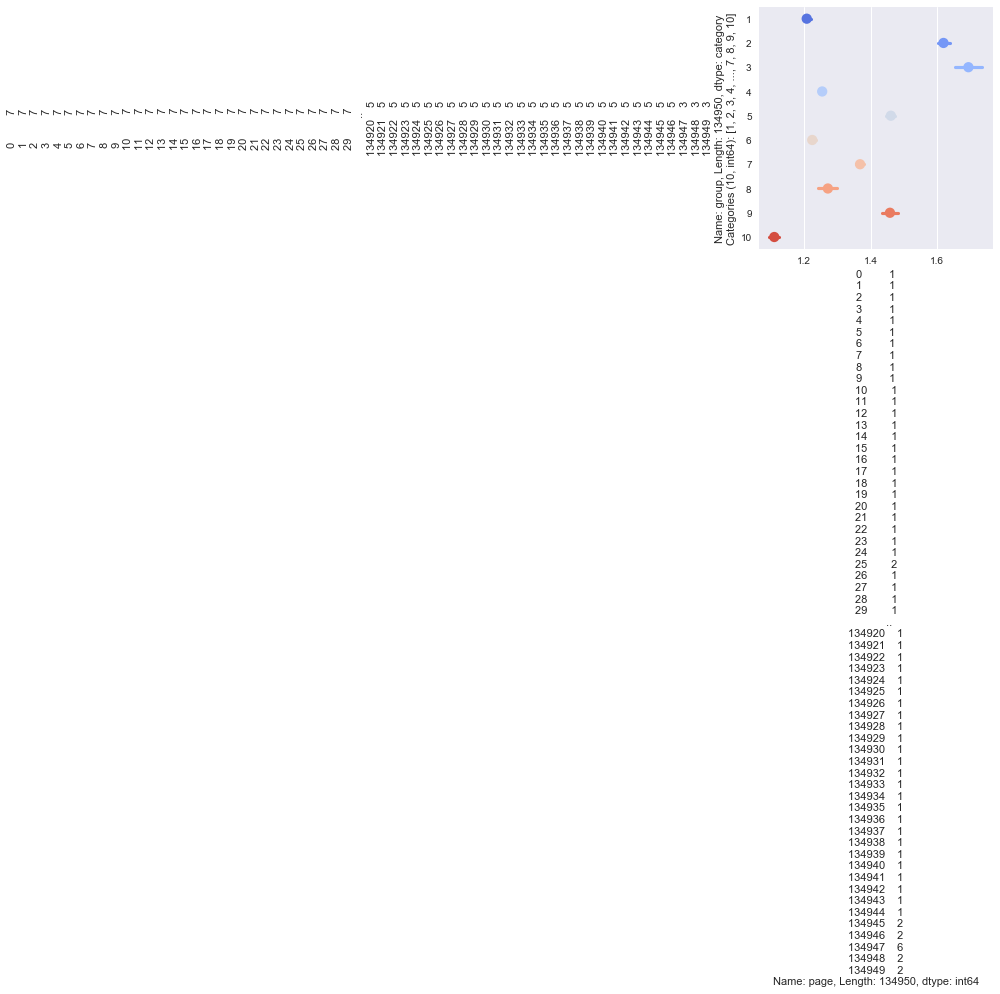

In [68]:
sns.factorplot(x = df['page'].astype(int), y = df['group'], data = df, palette="coolwarm")

ValueError: left cannot be >= right

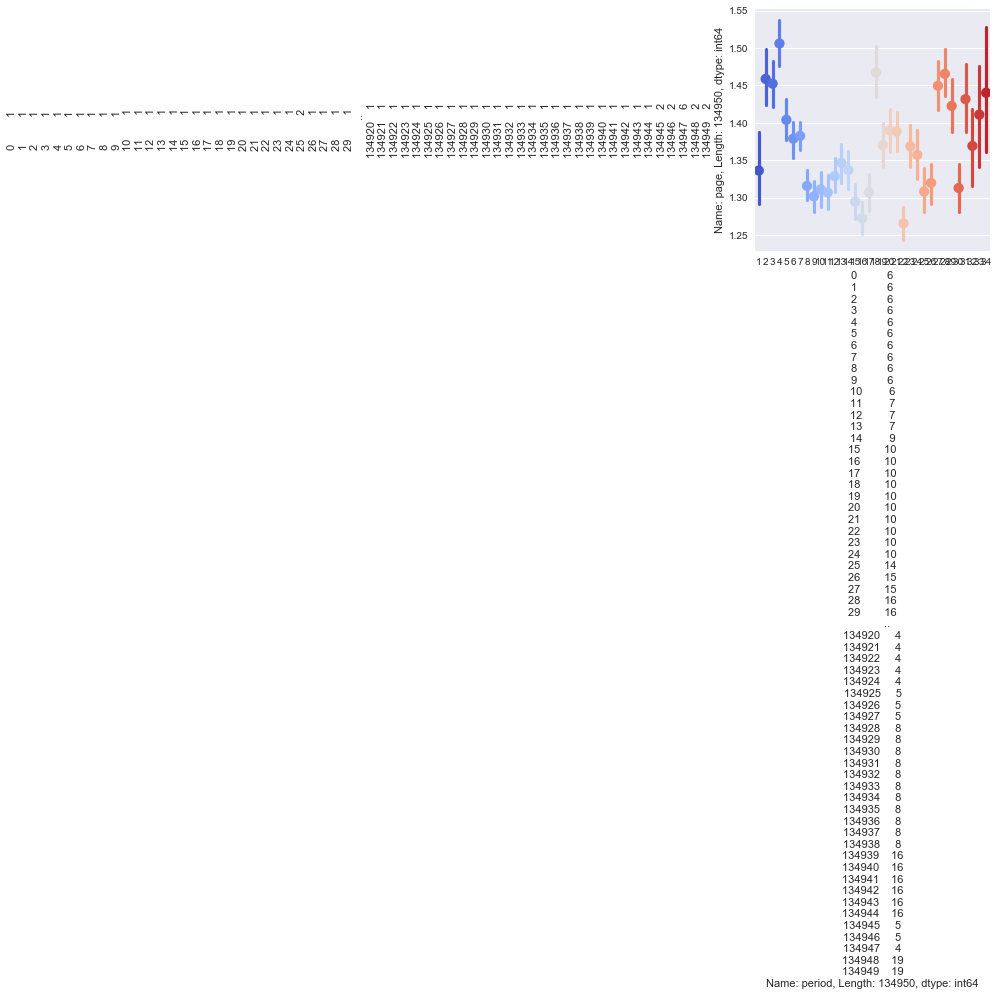

In [65]:
sns.factorplot(x = df['period'].astype(int), y = df['page'].astype(int), data = df, palette="coolwarm")